In [1]:
import os
import json
from pathlib import Path
import openai
import pandas as pd
import numpy as np
import logging
from IPython.display import clear_output
from copy import deepcopy
import networkx as nx
import matplotlib.pyplot as plt
import re

%matplotlib inline
%load_ext autoreload
%autoreload 2

from parse import parse

from finetuning import prepare_data
from utils import graph
from utils import utils
from nodes.node_functions import *
from utils.models_metadata import *

In [2]:
import ast

# playground

# setup

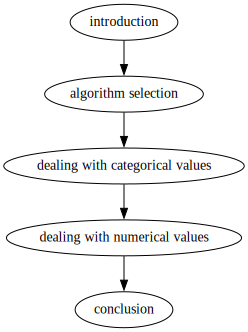

In [2]:
interview_graph = graph.create_interview_flowchart()

graph.plot_graph(interview_graph)

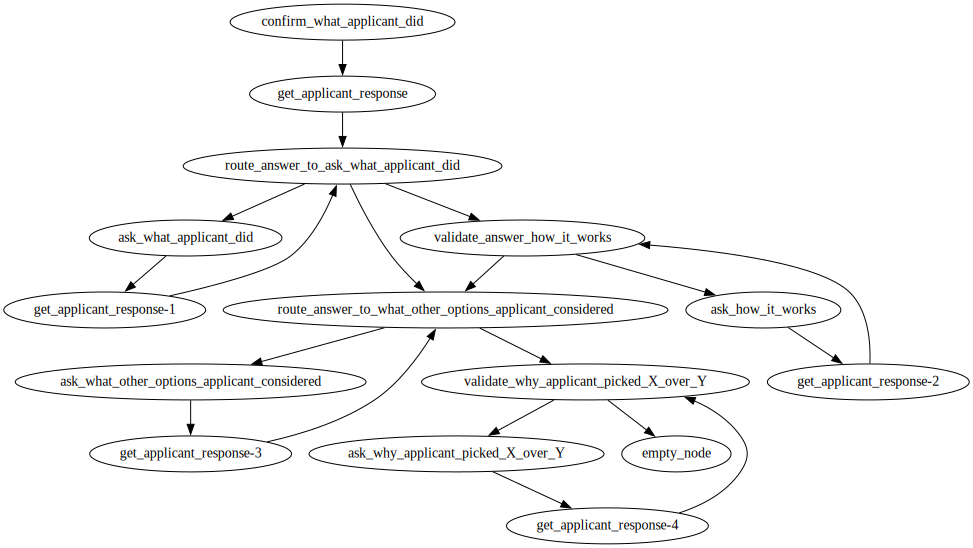

In [3]:
graph.plot_graph(interview_graph.nodes["algorithm selection"]['graph'])

graph.plot_graph(interview_graph.nodes["dealing with categorical values"]['graph'])

graph.plot_graph(interview_graph.nodes["dealing with numerical values"]['graph'])

# run

In [4]:
applicant_approaches = {
    'algorithm selection': 'GLM',
    'categorical encoding': 'binary encoding',
    'handling numerical variables': 'robust scaler'
}

In [5]:
data_challenge_objectives_and_contraints = """- Maximize model performance.
- Model interpretability is not a strong requirement."""

In [6]:
what_interviewer_thinks_applicant_has_done_in_ipynb = deepcopy(applicant_approaches)
# update what_interviewer_thinks_applicant_has_done_in_ipynb here

graph.add_function_arg_to_node(interview_graph.nodes["algorithm selection"]['graph'].nodes['confirm_what_applicant_did'],
                        'context',
                         what_interviewer_thinks_applicant_has_done_in_ipynb
                        )
graph.add_function_arg_to_node(interview_graph.nodes["dealing with categorical values"]['graph'].nodes['confirm_what_applicant_did'],
                        'context',
                         what_interviewer_thinks_applicant_has_done_in_ipynb
                        )
graph.add_function_arg_to_node(interview_graph.nodes["dealing with numerical values"]['graph'].nodes['confirm_what_applicant_did'],
                        'context',
                         what_interviewer_thinks_applicant_has_done_in_ipynb
                        )

In [7]:
carryover_data = {
    "applicant_data": {"applicant_skill_summary": {"technical_depth": np.random.randint(1, 4),
                                                "technical_breadth": np.random.randint(1, 4),
                                                "critical_thinking": np.random.randint(1, 4)},
                       "applicant_context": applicant_approaches,
                      },
    "what_interviewer_thinks_applicant_has_done_in_ipynb": what_interviewer_thinks_applicant_has_done_in_ipynb,
    "data_challenge_objectives_and_contraints": data_challenge_objectives_and_contraints,
}

# each list within this variable is the conversation in a particular section. each string within that list is the ordered dialogue from each member of the interview
chat_history_by_section = []
flattened_chat_history = ""

# list of the nodes that have been visited till the current point
sections_visited_names = []
nodes_visited_names = []

validate_async = False
is_interview_complete = False


current_section_name, current_section = graph.get_first_node_in_graph(interview_graph)
current_section_graph = current_section['graph']

In [19]:


# traverse through sections
while not is_interview_complete:
    chat_history_by_section.append([])
    current_node_name, current_node = graph.get_first_node_in_graph(current_section_graph)
    # print("\n\ncurrent section: " + current_section_name)
    # print("current node: " + current_node_name)
    is_section_complete = False
    # traverse within section
    while not is_section_complete:
        # access current node from current section
        # prep args for current node function
        current_node_function_args = deepcopy(current_node['function_args']) if 'function_args' in current_node else {}
        current_node_function_args['current_section_name'] = current_section_name
        current_node_function_args['carryover_data'] = carryover_data
        current_node_function_args['validate_async'] = validate_async
        current_node_function_args['chat_history_by_section'] = chat_history_by_section

        # call function
        current_node_output = current_node['function'](**current_node_function_args)
        
        if current_node_output['new_chat_lines']:
            # store return values in appropriate variables (chat_history)
            chat_history_by_section[-1].extend(current_node_output['new_chat_lines'])
            flattened_chat_history += "\n" + "\n".join(current_node_output['new_chat_lines'])
            clear_output()
            print(flattened_chat_history)
    
        # update nodes_visited
        nodes_visited_names.append(current_node_name)
    
        # figure out next node to visit
        current_node_name, current_node = graph.get_next_node(current_section_graph, current_node_name, current_node_output)
        if current_node_name is None:
            # prepare routing_value (result of a section)
            current_section_output = dict(routing_value=1, 
                                          new_chat_line=None) 
            is_section_complete = True

    
    sections_visited_names.append(current_section_name)
    # get new section
    current_section_name, current_section = graph.get_next_node(interview_graph, current_section_name, current_section_output)
    if current_section_name is None:
        is_interview_complete = True
        break
    current_section_graph = current_section['graph']



Interviewer: Thank you for taking the time out to interview with us. 
    In this interview, we will cover a range of topics and ask questions to assess your skill level as a Data Scientist. 
    If you don't understand a question, feel free to ask questions to get clarification.
    Let's get started.
Interviewer: Could you confirm whether you used a Generalised Linear Model for this task?
Applicant: Yes, I used a Generalised Linear Model for this task.
Interviewer: How does a Generalised Linear Model work?
Applicant: A Generalised Linear Model is a type of regression model that is used to predict a continuous outcome variable. It works by fitting a linear combination of the independent variables to the dependent variable using a link function. The link function is used to transform the output of the model into a range of values that is appropriate for the given data.
Interviewer: Besides a Generalised Linear Model, did you consider any other algorithms for this task?
Applicant: Yes,

In [11]:
# prepare_data.validate_observations_for_finetuning_from_queue()

# debug

In [ ]:
# # interview_graph.nodes["algorithm selection"]['graph'].nodes['ask_how_it_works']['function_args']['subject'] = "DBSCAN"

# # current_node = interview_graph.nodes["algorithm selection"]['graph'].nodes["validate_why_applicant_picked_X_over_Y"]

# current_node_function_args = deepcopy(current_node['function_args']) if 'function_args' in current_node else {}
# current_node_function_args['carryover_data'] = carryover_data
# current_node_function_args['current_section_name'] = "dealing with numerical values"
# current_node_function_args['validate_async'] = False
# # current_node_function_args['chat_history_by_section'] = [
# #     ["""Interviewer: Could you confirm whether you used a Generative Adversarial Network for this task?
# # Applicant: Yes, I used a Generative Adversarial Network for this task.
# # Interviewer: How does a Generative Adversarial Network work?
# # Applicant: GANs are deep learning models that produce fake data.
# # Interviewer: Besides GANs, did you consider any other algorithms for this task?
# # Applicant: Yes, I considered using autoencoders and also CNNs."""]
# # ]
# current_node_function_args['chat_history_by_section'] = chat_history_by_section

# current_node_output = current_node['function'](**current_node_function_args)